In [359]:
import pandas as pd

%matplotlib inline 
#Load hospital data
hospital_data = pd.read_pickle("data/merged_data_7May2020.pkl")

In [360]:
print(hospital_data['hospital'].unique())

['AssafHarofe' 'BneiZion' 'Barzilai' 'HilelYaffe' 'Galil' 'Volfson' 'Ziv'
 'Poriya' 'Rambam' 'Shiba']


In [362]:
hospital_data.rename(columns = lambda x : re.sub('\s*:\s*', '_', re.sub('-','_', x)), inplace=True)

In [341]:
#Run a smoothing filter on the hospitalization data
from scipy import signal
b, a = signal.butter(14, 0.07)

if (1):
  smoothed_merged_data = merged_data

  for column in smoothed_merged_data:
    if (column != "Date") and (column != "hospital"):
      smoothed_merged_data[column] = signal.filtfilt(b, a, smoothed_merged_data[column], padlen=7)
      #smoothed_merged_data[column] = smoothed_merged_data[column].rolling(window=14).mean()

  merged_data = smoothed_merged_data

In [364]:
# Read air quality sensor data
air_quality = pd.read_excel("data/StationData.xlsx")

air_quality.rename(columns = {'Unnamed: 0' : 'DateTime'}, inplace=True)
air_quality["DateTime"] = pd.to_datetime(air_quality["DateTime"])
air_quality["PollutionDate"] = air_quality["DateTime"].dt.date

# Many columns are empty or sparse. Require 80% availability of data per column
air_quality.dropna(thresh=len(air_quality)*0.8, axis=1, inplace=True)

In [365]:
# Mark column by the type of pollutants they measure

import re

air_quality.rename(columns=lambda x: re.sub('[- ()+.]','_', re.sub('2\.5', '25', re.sub('_', '__', x))), inplace=True)

colre_gaseous = re.compile('(O3|NO2|NO|NOX|SO2|TOC_SCRUBBER|TOC_RTO|CO|BENZN|O_Xyle|TOLUEN|EthylB|M_P_XY|1_3butadiene|TOL|NOx|H2S|CO TRAFIC|NO2_TRAFIC|NO_TRAFIC|NOX_TRAFIC)$')

colre_particulate = re.compile('(PM10|PM25|pm\(10-2\.5\)|pm_10_25_|DUST|PM1|BLACK CARBON)$')

colre_climate = re.compile('(StWd|RH|WDS|WDD|SR|PREC)$')  # not used, we take climate data from another source
colre_operational = re.compile('(ITemp|TEMP|Filter|LXpk_max|LAF_max|LAF_min|LAim|LXeq|LAeq|FILTER_2.5|spare|PM1_Flow|PM25_Filter|PM10_Noise|PM25_Noise|PM10_Filter|Flow)$')  # not used, this should not matter for anythingg

# There are two data columns which didn't seem to belong anywhere: BP and BRP. Anyone knows what they are?2

all_cols = air_quality.columns

aircols_gaseous = list(filter(colre_gaseous.search, all_cols))
aircols_particulate = list(filter(colre_particulate.search, all_cols))

#print(aircols_gaseous)
#print(aircols_particulate)


In [344]:
#Run a smoothing filter on the air quality data
from scipy import signal
b, a = signal.butter(14, 0.07)

if (0):
  smoothed_filtered_air_quality = filtered_air_quality
  smoothed_filtered_air_quality = smoothed_filtered_air_quality.fillna(-1)

  for column in smoothed_filtered_air_quality:
    if (column != "PollutionDate") and (column != "Date-Time") and (column != "DateTime"): 
      smoothed_filtered_air_quality[column] = signal.filtfilt(b, a, smoothed_filtered_air_quality[column], padlen=14)
      #smoothed_filtered_air_quality[column] = smoothed_filtered_air_quality[column].rolling(window=14).mean()

  filtered_air_quality = smoothed_filtered_air_quality

In [ ]:
import statsmodels.api as sm
from sklearn.ensemble import RandomForestRegressor
import numpy as np
from scipy.stats.stats import pearsonr   
from patsy import dmatrices, dmatrix

sep = ' + '

#lag = 0
hospital = 'Rambam'

weather_cols = [col for col in filtered_air_quality.columns if 'Date' not in col]

formula = sep.join(["all_visits ~ 1 ", sep.join(weather_cols)])
#print(formula)

correlations = pd.DataFrame(columns=['Lag', 'Cor'])

for lag in range(-60, 60):
  filtered_air_quality["ShiftedPollutionDate"] = pd.DatetimeIndex(filtered_air_quality["PollutionDate"]) + pd.DateOffset(lag);
  merged_all = pd.merge(merged_data, filtered_air_quality, how='left', left_on='Date', right_on='ShiftedPollutionDate')
  #merged_all = merged_all.fillna(-1)

  #Split to train and test
  train_row_mask = (merged_all["hospital"] == hospital) & (merged_all['Date'] <= '2018-12-31')
  test_row_mask  = (merged_all["hospital"] == hospital) & (merged_all['Date'] > '2018-12-31')

  y, X = dmatrices(formula, merged_all)
  y_train = y[train_row_mask]
  X_train = X[train_row_mask]
  y_test = y[test_row_mask]
  y_test = [ i[0] for i in y_test]
  X_test = X[test_row_mask]

  #rf = RandomForestRegressor(n_estimators = 10)
  #rf.fit(X_train, y_train);
  #pred = rf.predict(X_test)

  model = sm.OLS(y_train.astype(float), X_train.astype(float)).fit()
  pred  = model.predict(X_test.astype(float))

  #curCorr = y_test.corr(pred)

  curCorr = pearsonr(pred, y_test)
  curCorr = curCorr[0]

  correlations = correlations.append({'Lag': lag, 'Cor': curCorr}, ignore_index=True)
  print(".", end='')


In [ ]:
from scipy import signal
b, a = signal.butter(5, 0.2)

correlations2 = correlations
y = signal.filtfilt(b, a, correlations2['Cor'], padlen=5)
correlations2['Cor'] = y
#print(correlations2['Cor'])

correlations2.plot(kind='scatter',x='Lag',y='Cor',color='red')

In [368]:
#Read weather and inversion data
weather = pd.read_csv("data/weather.csv")

weather.rename(columns=lambda x: re.sub('[- ()+]','_', x), inplace=True)

weather["date"] = pd.to_datetime(weather["date"]).dt.date


In [369]:
# join all independent variables into one table
all_indep = air_quality.merge(weather, how='inner', left_on= "PollutionDate", right_on="date")

In [370]:
# Inner loop of test procedure
# Shift the independent variabls by (lag) days, try to predict the dependent variable, and report 
# the correlation of prediction on a (similarly shifted) test set

import statsmodels.api as sm
import numpy as np
from patsy import dmatrices, dmatrix

def pred_cor(inputs, outputs, lag, formula, hospital):

  inputs["ShiftedPollutionDate"] = pd.DatetimeIndex(inputs["PollutionDate"]) + pd.DateOffset(lag)

  merged_all = pd.merge(outputs, inputs, how='left', left_on='Date', right_on='ShiftedPollutionDate')
  merged_all = merged_all.fillna(-1)

  #Split to train and test
  train_row_mask = (merged_all["hospital"] == hospital) & (merged_all['Date'] <= '2018-12-31')
  test_row_mask  = (merged_all["hospital"] == hospital) & (merged_all['Date'] > '2018-12-31')

  y, X = dmatrices(formula, merged_all)
  y_train = y[train_row_mask]
  X_train = X[train_row_mask]
  y_test = y[test_row_mask]
  y_test = [ i[0] for i in y_test]
  X_test = X[test_row_mask]

  model = sm.OLS(y_train.astype(float), X_train.astype(float)).fit()
  pred  = model.predict(X_test.astype(float))

  return np.corrcoef(y_test, pred)[0,1]


In [407]:
# Set up sets of features
from itertools import chain, combinations, product

inversion_basic = ['inversion_bywind', 'inversion_bytemp_delta', 'inversion_byboth']
cols_climate = ["hmd_rlt_Bazan", "prs_lvl_hgt_Bazan", "tmp_air_dry_Bazan", "tmp_air_wet_Bazan", "tmp_dew_pnt_Bazan", "wind_dir_Bazan", "wind_spd_Bazan"]

# add pairs of inversion/climate variables
# also include the original inversion variable, and the original climate variables
inversion_cols = inversion_basic.copy()
inversion_cols.extend(map(lambda x: ':'.join(x), product(inversion_basic, cols_climate)))
inversion_cols.extend(cols_climate)

colmap = {
    'gaseous' : aircols_gaseous,
    'particulate' : aircols_particulate,
    'climate' : cols_climate,
    'climate+' : inversion_cols
}

all_subsets = chain.from_iterable(combinations(colmap,n) for n in range(1, len(xs)+1))

In [ ]:
sep = ' + '
sep2 = ','

hospital = 'Rambam'

correlations = {}

for colset in all_subsets:
  colset_name = sep2.join(colset)
  print("\n" + colset_name)
  all_lists = (map(lambda x : colmap[x], colset))
  #print(list(all_lists))
  all_items = [item for sublist in all_lists for item in sublist]

  cols = all_items

  formula = sep.join(["all_visits ~ 1", sep.join(cols)])
  #print(formula)

  corrs = pd.DataFrame(columns=['Lag', 'Cor'])

  for lag in range(-60, 60):
    c = pred_cor(all_indep, hospital_data, lag, formula, hospital)
    corrs = corrs.append({'Lag': lag, 'Cor': c }, ignore_index=True)
    print(".", end='')

  correlations[colset_name] = corrs

In [409]:
#np.save('data/corr.npy', correlations)

In [ ]:
#correlations = np.load('data/corr.npy',allow_pickle='TRUE').item()

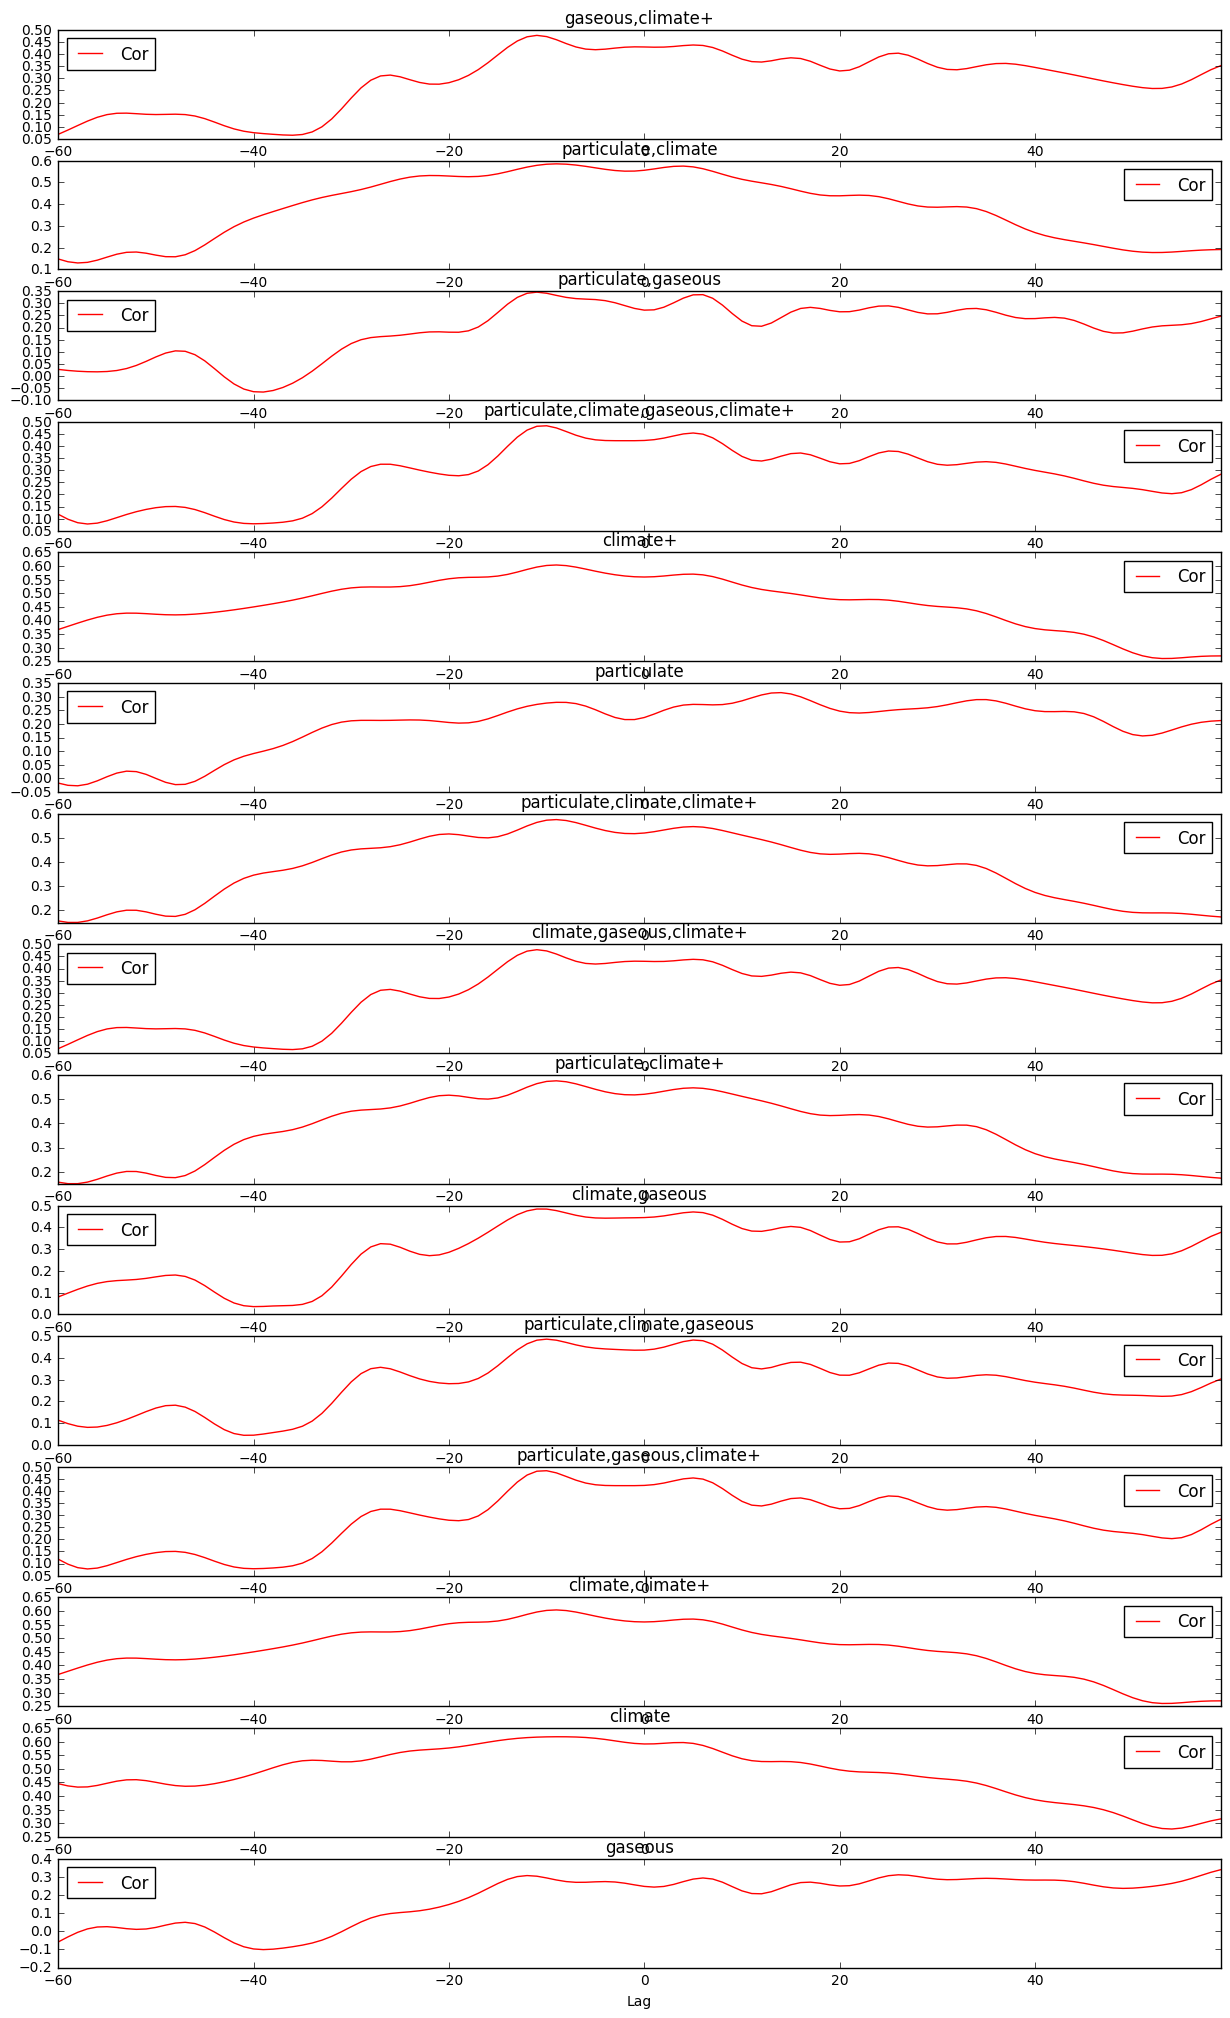

In [412]:
import matplotlib.pyplot as plt

ks = list(correlations.keys())
n = len(ks)

plt.figure()

fig, axes = plt.subplots(nrows=n, ncols=1, figsize=(15, 25))

for i in range(len(ks)):
  ki = ks[i]
  b, a = signal.butter(5, 0.2)
  v = correlations[ki].copy()
  y = signal.filtfilt(b, a, v['Cor'], padlen=5)
  v['Cor'] = y
  v.plot(kind='line',x='Lag',y='Cor',color='red', title=ki, ax=axes[i])

plt.show()